# Text Classification (Spam and Non-spam Texts)

This file contains the algorithm (along with complete description) for classification of spam and non-spam text messages using different well-known feature extraction techniques like Term Frequency, Inverse-Document Frequency, etc. and feature selection techniques like Variance Thresholding and Document Frequency Thresholding. Lingspam dataset was used for classification.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import os, re
from collections import OrderedDict, Counter
from sklearn.utils import shuffle
import pandas as pd

In [4]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

# Data Loading

1. Loading dataset of spam and non-spam messages obtained from http://www.aueb.gr/users/ion/data/lingspam_public.tar.gz. Each file contains raw text message and the classes (spam(1) and non-spam(0)) can be identified by th presence or absence of the substring 'spmsg' in the filename. Each file is a txt file.

In [6]:
lingspam_dataset_dir = "spam_dataset\\lingspam_public\\bare\\"

raw_text_all = []  # List of raw text data
labels_all = [] # Labels for each raw data
label_map = ['not spam', 'spam']
lingspam_file_ext = "txt"
spam_file_identifier = "spmsg"


# Load dataset
def extract_text_and_class(fp):
    # Read the contents from the file
    with open(fp, 'r') as f:
        text = f.read()
    # If content is available
    if len(text) > 0:
        # Add the class as a spam if the file name has specified substring
        if spam_file_identifier in fp:
            label = 1
        else:
            label = 0
        return text, label
    return None, None
        
def load_lingspam_data_urls(url, data=[]):
    # If the current url is a directory, then load tet files recursively
    if os.path.isdir(url):
        # For each file in the current directory
        for file in os.listdir(url):
            fp = os.path.join(url, file)
            # If the file is a directory, then load data from it
            if os.path.isdir(fp):
                data = load_lingspam_data_urls(fp, data)
            # Else if the file is a text file
            elif os.path.isfile(fp) and lingspam_file_ext in fp:
                data.append(fp)  # Add url of the file
    # Else if the current url is a text file
    elif os.path.isfile(url) and lingspam_file_ext in url:
        data.append(url)  # Add url of the file
    return data    
                
raw_urls = load_lingspam_data_urls(lingspam_dataset_dir, [])
raw_urls = shuffle(raw_urls)

total_samples = 2000  # Total max data samples
spam_samples = int(total_samples/2)  # Total max samples containing spam texts
nonspam_samples = total_samples - spam_samples # Total max samples containing non-spam texts



spam_counter = 0
nspam_counter = 0
i=0
#while (spam_counter < spam_samples) or (nspam_counter < nonspam_samples):
while i < len(raw_urls):
    #print("Left: " + str(total_samples - len(raw_text)))
    printProgressBar(i, len(raw_urls))
    text, label = extract_text_and_class(raw_urls[i])  # Extract the text and class
    if not (text is None):
        if label == 1 and (spam_counter < spam_samples):
            text = text.replace("\n", " ")  # Replace newline with space
            text = text.replace("\t", " ")  # Replace tab with space
            text = text.replace("\n", " ")  # Replace newline with space
            text = re.sub("\s+", " ", text)

            w = text.split(" ")
            n_w = []
            for j in range(len(w)):
                # Skip words containing single character
                if len(w[j]) > 1:
                    n_w.append(w[j])
            raw_text_all.append(n_w)
            labels_all.append(label)
            spam_counter += 1
        elif label == 0 and (nspam_counter < nonspam_samples):
            text = text.replace("\n", " ")  # Replace newline with space
            text = text.replace("\t", " ")  # Replace tab with space
            text = text.replace("\n", " ")  # Replace newline with space
            text = re.sub("\s+", " ", text)

            w = text.split(" ")
            n_w = []
            for j in range(len(w)):
                # Skip words containing single character
                if len(w[j]) > 1:
                    n_w.append(w[j])
            raw_text_all.append(n_w)
            labels_all.append(label)
            nspam_counter += 1    
    i += 1
# Split Evaluation and training data
print("\n")
split_index = int(len(raw_text_all)*4/5)
raw_text_all, labels_all = shuffle(raw_text_all, labels_all)
raw_text, labels = raw_text_all[:split_index], labels_all[:split_index]
raw_text_eval, labels_eval = raw_text_all[split_index:], labels_all[split_index:]
print("Total samples collected: " + str(len(raw_text_all)) + ", Train:" + str(len(raw_text)) + ", Eval: " + str(len(raw_text_eval)))

Total samples collected: 1481, Train:1184, Eval: 297█████████████████████████████████████████████████-| 100.0% 


In [7]:
all_samples =np.unique(labels_all, return_counts=True)[1]
train_samples = np.unique(labels, return_counts=True)[1]
eval_samles = np.unique(labels_eval, return_counts=True)[1]
print("Total (non-spam, spam) samples for All: " + str(all_samples) + ", Train: " + str(train_samples) + ", Eval: " + str(eval_samles))

Total (non-spam, spam) samples for All: [1000  481], Train: [805 379], Eval: [195 102]


# Data PreProcessing

## 1. Stop-Words
Remove stops from all texts in order to reduce the number of words in order to process. Stop-words are language-specific functional words, are frequent words that carry no information (i.e., pronouns, prepositions, conjunctions). In English language, there are about 400- 500 Stop words. Examples of such words include 'the', 'of', 'and', 'to'. The first step during preprocessing is to remove these Stop words, which has proven as very important. Many of the most frequently used words in English sentence are useless in Information Retrieval (IR) and text mining.

## Stop-Word Detection

The frequency of each word over single or multiple documents will be used to determine stop-words in a text. The words with an inter-document frequency greater than or equal 1 are considered as stop-words.

## Inter-Document Frequency over all documents

It is the number of times a word occurred across all documents divided by the total number of documents. It will provide an estimation of the frequency of the word per document. The  equation for Inter-Document Frequency '$F_R(W)$' for a word '$W$' is as follows:

\begin{equation}
F_R(W) = \frac{\sum_{i, j}^{n, m} X_j^{d_i}}{\sum_i^{n} 1}
\end{equation}

Here,

1. W = Word whose frequency needs to be determined

2. $X_j^{d_i}$ is 1 if the word(W) occurs in $j^{th}$ index of the $i^{th}$ document(d) and the total number of documents is 'n' with each document containing variable(m) number of words. Else, it is zero.

## Inter-Document Frequency over spam documents

\begin{equation}
F_R^S(W) = \frac{\sum_{i, j}^{p, m} X_j^{d_i}}{\sum_i^{p} 1}
\end{equation}

Here 'p' is the number of spam documents or text corpus in the dataset.


## Inter-Document Frequency over Non-spam documents

\begin{equation}
F_R^N(W) = \frac{\sum_{i, j}^{q, m} X_j^{d_i}}{\sum_i^{q} 1}
\end{equation}

Here 'q' is the number of spam documents or text corpus in the dataset such that $q=n-p$.

In [8]:
# Generate a word map containing each unique word and the corresponding indices of each document in which the word occurs
word_map = OrderedDict()
for i in range(len(raw_text)):
    printProgressBar(i, len(raw_text))
    for j in range(len(raw_text[i])):
        word = raw_text[i][j].lower()
        if not (word in word_map.keys()):
            word_map[word] = [(i, j)]
        else:
            word_map[word].append((i, j))
print("\nTotal Words: " + str(len(word_map.keys())))

 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.9% 
Total Words: 37513


In [9]:
# Calculate Inter-Document Frequency and Average Intra-Document Frequency of the words for all documents, spam and non-spam documents
words = word_map.keys()
inter_doc_freq = np.zeros(len(words))
inter_doc_freq_spam = np.zeros(len(words))
inter_doc_freq_not_spam = np.zeros(len(words))
intra_doc_freq = np.zeros(len(words))
avg_freq = np.zeros(len(words))

# For each word in the map
i = 0

for word in words:
    # Calculate the frequency of the word across all documents/data samples
    #print("Words left: " + str(len(words) - i))
    printProgressBar(i, len(words) , prefix = 'Computed Frequency-Progress:', suffix = 'Complete', length = 50)
    inter_doc_freq[i] = len(word_map[word])/len(raw_text)
    # Find the list of documents in which the word appears
    docs = []
    for j in range(len(word_map[word])):
        docs.append(word_map[word][j][0])
        if labels[word_map[word][j][0]] == label_map.index("spam"):
            inter_doc_freq_spam[i] += 1
        else:
            inter_doc_freq_not_spam[i] += 1
    inter_doc_freq_spam[i] /= len(np.where( np.asarray(labels) == label_map.index("spam") )[0])
    inter_doc_freq_not_spam[i] /= len(np.where( np.asarray(labels) == label_map.index("not spam") )[0])
        
    docs = Counter(docs)
    
    
    # Calculate the frequency of the word across all words in all data samples
    avg_freq[i] += len(word_map[word])
    
    # Calculate the average frequency of the word occuring within each document
    times_appeared = np.zeros(len(raw_text))
    for doc in docs.keys():
        times_appeared[doc] = docs[doc]/len(raw_text[doc])
    intra_doc_freq[i] = np.average(times_appeared)
    i += 1
avg_freq /= i
    


<IPython.core.display.Javascript object>


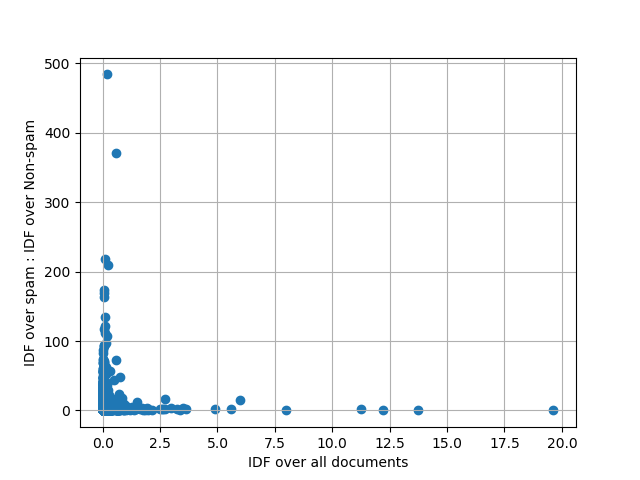

E:\Anaconda3.5.2.0\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [10]:
# Visualize scatter plot for inter-doc frequency of words over all documents vs
# ratio between inter-doc frequency of words over all spam and non-spam documents
plt.close(1)
fig1 = plt.figure(1)
plt.clf()

plt.xlabel("IDF over all documents")
plt.ylabel("IDF over spam : IDF over Non-spam")
plt.grid()

plt.scatter(inter_doc_freq, inter_doc_freq_spam/inter_doc_freq_not_spam)

In [11]:
# Arrange the frequencies in a descending order for each word
from pandas import ExcelWriter
sorted_index = np.flip(np.argsort(inter_doc_freq), axis=0)
all_words = (np.asarray(list(word_map.keys())))[sorted_index]
sorted_avg_freq = avg_freq[sorted_index]
sorted_inter_freq = inter_doc_freq[sorted_index]
sorted_inter_freq_spam = inter_doc_freq_spam[sorted_index]
sorted_inter_freq_not_spam = inter_doc_freq_not_spam[sorted_index]
sorted_intra_freq = intra_doc_freq[sorted_index]

all_data = np.vstack((all_words.T, sorted_inter_freq.T))
all_data = np.vstack((all_data, sorted_inter_freq_spam.T))
all_data = np.vstack((all_data, sorted_inter_freq_not_spam.T))
all_data = np.vstack((all_data, sorted_avg_freq.T))
all_data = np.vstack((all_data, sorted_intra_freq.T))
all_data = all_data.T

df = pd.DataFrame(all_data, columns=['Word', 'Inter-Doc Freq(All)', 'Inter-Doc Freq(Spam)', 'Inter-Doc Freq(Not Spam)', 'Average Freq.', 'Intra-Doc Freq'])


In [12]:
# Save the table as an Excel File
table_path = "word_frequency_no_stop_no_stem.xlsx"
excel_writer = ExcelWriter(table_path)
df.to_excel(excel_writer, index=True, sheet_name="Sheet1")
excel_writer.save()

In [13]:
# Obtain Stop-words
stop_words = all_words[sorted_inter_freq >= 1]
print(stop_words)

['the' 'of' 'and' 'to' 'in' 'you' 'for' 'is' 'on' 'this' 'be' 'that' 'it'
 'your' 'will' 'or' 'are' 'with' 'as' 'from' 'by' 'have' 'at' 'university'
 'language' 'we' 'not' '20' 'can' "'s" 'if' 'all' 'an' 'do' 'information'
 '00' 'more' 'one' 'email' 'subject:']


In [15]:
# Remove stop words from all texts
stop_removed_text = []
stop_removed_label = []
for i in range(len(raw_text)):
    #print("Left: " + str(len(raw_text)-i))
    printProgressBar(i, len(raw_text) , prefix = 'Train-Progress:', suffix = 'Complete', length = 50)
    stop_removed = []
    for j in range(len(raw_text[i])):
        word = raw_text[i][j].lower()
        if not (word in stop_words):
            stop_removed.append(word)
    if len(stop_removed) > 0:
        stop_removed_text.append(stop_removed)
        stop_removed_label.append(labels[i])
print("\nTotal Stop removed training data: " + str(len(stop_removed_text)))

stop_removed_text_eval = []
stop_removed_label_eval= []
for i in range(len(raw_text_eval)):
    #print("Left: " + str(len(raw_text_eval)-i))
    printProgressBar(i, len(raw_text_eval) , prefix = 'Evaluation-Progress:', suffix = 'Complete', length = 50)
    stop_removed = []
    for j in range(len(raw_text_eval[i])):
        word = raw_text_eval[i][j].lower()
        if not (word in stop_words):
            stop_removed.append(word)
    if len(stop_removed) > 0:
        stop_removed_text_eval.append(stop_removed)
        stop_removed_label_eval.append(labels_eval[i])
        
print("\nTotal Stop removed evaluation data: " + str(len(stop_removed_text_eval)))

Train-Progress: |█████████████████████████████████████████████████-| 99.9% Complete
Total Stop removed training data: 1184
Evaluation-Progress: |█████████████████████████████████████████████████-| 99.7% Complete
Total Stop removed evaluation data: 297


# Data PreProcessing

## 2. Stemming
Stemming techniques are used to find out the root/stem of a word. Stemming converts words to their stems, which incorporates a great deal of language-dependent linguistic knowledge. Behind stemming, the hypothesis is that words with the same stem or word root mostly describe same or relatively close concepts in text and so words can be conflated by using stems. For example, the words, user, users, used, using all can be stemmed to the word 'USE'. In the present work, the Porter Stemmer algorithm, which is the most commonly used algorithm in English, is used. 

# Feature Extraction

Feature extraction is performed for identifying spam and non-spam text from a set of documents where each document contains a single text corpus. The features obtained from each text corpus are as follows:

## Total Inter-Document Frequency over all documents

Sum of inter-document frequency over all documents($F_R(W)$) for each word in the text corpus will be known as the total inter-dependent frequency over all documents($T_{F_R}$). If the word is not enlisted in the word-map then its inter-document frequency is considered as zero (in order to exclude the word from calculation). The equation is as follows:

\begin{equation}
T_{F_R}(d) = \sum_{i=0}^m F_R(W_i)
\end{equation}

Here, $F_R(W)$ is the inter-document frequency of the word obtained over all documents(d).

\begin{equation}
F_R(W) = \frac{\sum_{i, j}^{n, m} X_j^{d_i}}{\sum_i^{n} 1}
\end{equation}

## Total Inter-Document Frequency over spam documents

Sum of inter-document frequency over spam documents($F_R^S(W)$) for each word in the text corpus will be known as the total inter-dependent frequency over spam documents($T_{F_R^S}$). If the word is not enlisted in the word-map then its inter-document frequency is considered as zero (in order to exclude the word from calculation). The equation is as follows:

\begin{equation}
T_{F_R^S}(d) = \sum_{i=0}^m F_R^S(W_i)
\end{equation}

Here, $F_R(W)$ is the inter-document frequency of the word obtained over all documents(d).

\begin{equation}
F_R^S(W) = \frac{\sum_{i, j}^{p, m} X_j^{d_i}}{\sum_i^{p} 1}
\end{equation}

## Total Inter-Document Frequency over Non-Spam documents

Sum of inter-document frequency over non-spam documents($F_R^N(W)$) for each word in the text corpus will be known as the total inter-dependent frequency over non-spam documents($T_{F_R^N}$). If the word is not enlisted in the word-map then its inter-document frequency is considered as zero (in order to exclude the word from calculation). The equation is as follows:

\begin{equation}
T_{F_R^N}(d) = \sum_{i=0}^m F_R^N(W_i)
\end{equation}

Here, $F_R(W)$ is the inter-document frequency of the word obtained over all documents(d).

\begin{equation}
F_R^N(W) = \frac{\sum_{i, j}^{n-p, m} X_j^{d_i}}{\sum_i^{n-p} 1}
\end{equation}

In [17]:
# Extract the three features from each document thereby creating the feature vector
def calculate_total_idf(document):
    total_idf = 0
    for i in range(len(document)):
        word = document[i].lower()
        if word in all_words:
            total_idf += sorted_inter_freq[np.where(all_words == word)[0]]
    return total_idf

def calculate_spam_idf(document):
    total_idf = 0
    for i in range(len(document)):
        word = document[i].lower()
        if word in all_words:
            total_idf += sorted_inter_freq_spam[np.where(all_words == word)[0]]
    return total_idf

def calculate_nspam_idf(document):
    total_idf = 0
    for i in range(len(document)):
        word = document[i].lower()
        if word in all_words:
            total_idf += sorted_inter_freq_not_spam[np.where(all_words == word)[0]]
    return total_idf

def calculate_all_idfs(document):
    idf = 0
    idfs = 0
    idfn = 0    
    for i in range(len(document)):
        word = document[i].lower()
        loc = np.where(all_words == word)[0]
        if len(loc) > 0:
            idf += sorted_inter_freq[loc]
            idfs += sorted_inter_freq_spam[loc]
            idfn += sorted_inter_freq_not_spam[loc]
    return [idf, idfs, idfn]

feature_data = []
feature_label = []
for i in range(len(stop_removed_text)):
    #print("Left: " + str(len(stop_removed_text) - i))
    printProgressBar(i, len(stop_removed_text) , prefix = 'Train-Progress:', suffix = 'Complete', length = 50)
    feature_data.append(calculate_all_idfs(stop_removed_text[i]))
    feature_label.append(stop_removed_label[i])
feature_data = np.asarray(feature_data)
feature_data = feature_data/feature_data.max()
feature_data = np.reshape(feature_data, (-1, 3))
feature_label = np.asarray(feature_label)
print("\nFeature vector shape for training data: " + str(feature_data.shape))


feature_data_eval = []
feature_label_eval = []
for i in range(len(stop_removed_text_eval)):
    #print("Left: " + str(len(stop_removed_text_eval) - i))
    printProgressBar(i, len(stop_removed_text_eval) , prefix = 'Evaluation-Progress:', suffix = 'Complete', length = 50)
    feature_data_eval.append(calculate_all_idfs(stop_removed_text_eval[i]))
    feature_label_eval.append(stop_removed_label_eval[i])
feature_data_eval = np.asarray(feature_data_eval)
feature_data_eval = feature_data_eval/feature_data_eval.max()
feature_data_eval = np.reshape(feature_data_eval, (-1, 3))
feature_label_eval = np.asarray(feature_label_eval)
print("\nFeature vector shape for evaluation data: " + str(feature_data_eval.shape))


Train-Progress: |█████████████████████████████████████████████████-| 99.9% Complete
Feature vector shape for training data: (1184, 3)
Train-Progress: |█████████████████████████████████████████████████-| 99.7% Complete
Feature vector shape for evaluation data: (297, 3)


<IPython.core.display.Javascript object>


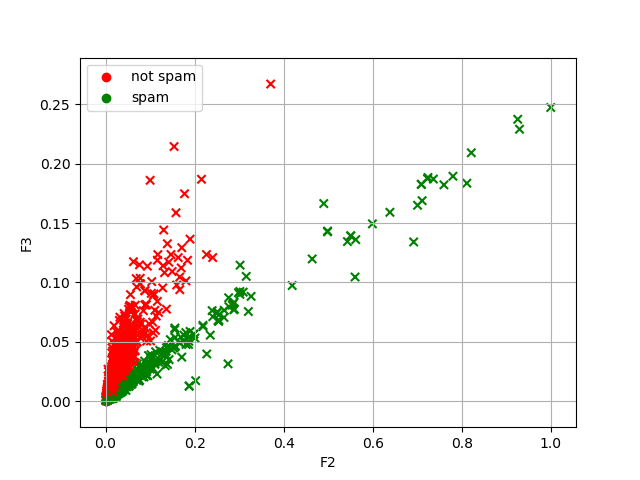

In [18]:
plt.close(2)
fig2 = plt.figure(2)
plt.clf()

plt.xlabel("F2")
plt.ylabel("F3")
plt.grid()

colors = ['red', 'green']
plt.scatter(feature_data[:, 1], feature_data[:, 2], c=np.asarray(colors)[feature_label], marker='x')
plt.scatter([0], [0], c=colors[0], label=label_map[0])
plt.scatter([0], [0], c=colors[1], label=label_map[1])

plt.legend()


# Feature Extraction(2)

## Term Frequency - Inverse Document Frequency(TF-IDF)

In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.[1] It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

The equation for term-frequency-inverse-dcument-frequency(tf-idf) of a term(e.g. word) 't' in a document corpus or dataset '$D = {d_1, d_2, ..., d_n}$' is as follows:

\begin{equation}
tf-idf(t, D) = tf(t, d) . idf(t, D)
\end{equation}

Here,

- $tf(t,d)$ is the term-frequency(tf) of a term 't' in a document 'd' that belongs to a document corpus 'D'.

- $idf(t, D)$ is the inverse document frequency(idf) of a term 't' in a document corpus 'D'.


## Term Frequency

Suppose we have a set of English text documents and wish to rank which document is most relevant to the query, "the brown cow". A simple way to start out is by eliminating documents that do not contain all three words "the", "brown", and "cow", but this still leaves many documents. To further distinguish them, we might count the number of times each term occurs in each document; the number of times a term occurs in a document is called its term frequency. However, in the case where the length of documents varies greatly, adjustments are often made (see definition below). The first form of term weighting is due to Hans Peter Luhn (1957) which may be summarized as:

- The weight of a term that occurs in a document is simply proportional to the term frequency.

The equation for term frequency '$tf(t,d)$' of a term 't' (e.g. word) in the document 'd' is as follows:
\begin{equation}
tf(t,d) = \frac{f_{t, d}}{\sum_{t' \in d} f_{t', d}}
\end{equation}

Here,

- $f_{t,d}$ is the raw count of the term 't' i.e. the number of times where 't' appears in the document 'd'.

- $tf(t,d)$ is the number of times the term appeared in document 'd' divided by the total number of terms '$f_{t', d}$' in docment 'd'. $t'$ is a term that appears in document 'd'.

Other variants of term frequency includes:

1. Boolean "frequencies": tf(t,d) = 1 if t occurs in d and 0 otherwise;


2. Logarithmically scaled frequency: tf(t,d) = log (1 + ft,d);


3. Augmented frequency, to prevent a bias towards longer documents, e.g. raw frequency divided by the raw frequency of the most occurring term in the document:



## Inverse Document Frequency

Because the term "the" is so common, term frequency will tend to incorrectly emphasize documents which happen to use the word "the" more frequently, without giving enough weight to the more meaningful terms "brown" and "cow". The term "the" is not a good keyword to distinguish relevant and non-relevant documents and terms, unlike the less-common words "brown" and "cow". Hence an inverse document frequency factor is incorporated which diminishes the weight of terms that occur very frequently in the document set and increases the weight of terms that occur rarely.

Karen Spärck Jones (1972) conceived a statistical interpretation of term specificity called Inverse Document Frequency (idf), which became a cornerstone of term weighting:

- The specificity of a term can be quantified as an inverse function of the number of documents in which it occurs.

The equation for Inverse Document Frequency(IDF) '$idf(t, D)$' for a term 't' in a document corpus or dataset 'D' is as follows:

\begin{equation}
idf(t, D) = log \frac{N}{| {d \in D : t \in D} |}
\end{equation}

Here,

- N is the total number of documents(d) in the dataset or docment corpus 'D'.

- $| {d \in D : t \in D} |$ is the number of documents(d) where the term(t) appears. If the term is not in the corpus, this will lead to a division-by-zero. It is therefore common to adjust the denominator to


\begin{equation}
idf(t, D) = log \frac{N}{| 1 + {d \in D : t \in D} |}
\end{equation}


In [19]:
# Calculate raw count for a word in a text
def calculate_raw_count(term, document):
    return len(np.where(np.asarray(document) == term)[0])

# Calculate term-frequency for a word in a text corpus
def calculate_term_frequency(term, document):
    raw_count_term = calculate_raw_count(term, document)
    total_counts = np.sum(np.unique(np.asarray(document), return_counts=True)[1])
    return raw_count_term/total_counts

# Calculate boolean term-freuquency for a word in a text corpus
def calculate_boolean_term_frequency(term , document):
    if term in document:
        return 1
    else:
        return 0
    
# Calculate logarithmically scaled frequency
def calculate_log_scale_frequency(term, document):
    return np.log(1 + calculate_raw_count(term, document))

# Calculate Augmented Frequency of a word in a document
def calculate_augmented_frequency(term, document):
    values, counts = np.unique(np.asarray(document), return_counts=True)
    return calculate_raw_count(term, document) / calculate_raw_count(values[np.argmax(counts)], document)


# Calculate inverse-document-frequency of a word in a document
def calculate_idf(term, doc_corpus):
    count = 0
    for i in range(len(doc_corpus)):
        if term in doc_corpus[i]:
            count += 1
    return np.log(len(doc_corpus) / (1+count))

def calculate_tf_idf(term, doc, doc_corpus):
    return calculate_term_frequency(term, doc) * calculate_idf(term, doc_corpus)
# Create Feature Vector using tf-idf extracted from each document or text

# Create a modified word-map by removing words according to the preprocessing step mentioned in DOI: 10.1109/WI.2003.1241300
modified_word_map = []
highest_chars = 20  # Maximum characters that a valid word can have
for word in word_map.keys():
    # Do not add words that only appears once in the corpus or dataset
    if len(word_map[word]) > 1:
        # Do not add words with characters greater than 20
        if len(word) < highest_chars:
            
            modified_word_map.append(word)
print("Original wordmap: " + str(len(word_map.keys())) + " Modified wordmap: " + str(len(modified_word_map)))

term_frequencies = []
inverse_document_frequency = []

for i in range(len(stop_removed_text)):
    #print("Left: " + str(len(stop_removed_text) - i))
    printProgressBar(i, len(stop_removed_text) , prefix = 'Train-Progress:', suffix = 'Complete', length = 50)
    tf = []
    #idf = []
    for word in modified_word_map:
        tf.append(calculate_term_frequency(word, stop_removed_text[i]))
        #idf.append(calculate_idf(word, stop_removed_text))
    term_frequencies.append(tf)
    #inverse_document_frequency.append(idf)
    
term_frequencies = np.asarray(term_frequencies)
#inverse_document_frequency = np.asarray(inverse_document_frequency)
print("\nFeature vector shape for training dataset: " + str(term_frequencies.shape))

term_frequencies_eval = []
inverse_document_frequency_eval = []


for i in range(len(stop_removed_text_eval)):
    #print("Left: " + str(len(stop_removed_text_eval) - i))
    printProgressBar(i, len(stop_removed_text_eval) , prefix = 'Evaluation-Progress:', suffix = 'Complete', length = 50)
    tf = []
    #idf = []
    for word in modified_word_map:
        tf.append(calculate_term_frequency(word, stop_removed_text_eval[i]))
        #idf.append(calculate_idf(word, stop_removed_text))
    term_frequencies_eval.append(tf)
    #inverse_document_frequency.append(idf)
    
term_frequencies_eval = np.asarray(term_frequencies_eval)
#inverse_document_frequency = np.asarray(inverse_document_frequency)
print("\nFeature vector shape for evaluation dataset: " + str(term_frequencies_eval.shape))

Original wordmap: 37513 Modified wordmap: 18828
Train-Progress: |█████████████████████████████████████████████████-| 99.9% Complete
Feature vector shape for training dataset: (1184, 18828)
Evaluation-Progress: |█████████████████████████████████████████████████-| 99.7% Complete
Feature vector shape for evaluation dataset: (297, 18828)


# Feature Selection

Source Journal: A comparative study on feature selection in text categorization
First Author: Yiming Yang


Feature Selection is a technique used in bag of word model in order to reduce the number of unique terms (e.g. words) in the document corpus by removing the terms which carry the least amount of information useful for categorization. Generally, even a small document or text corpus may contain hundreds or even thousands of unique terms. If each term is treated as a feature vector for each document then the dimension of feature vector will become very large and unmanageable for classification. Therefore, different dimensionality reduction techniques (also known as feature selection techniques) are used on the feature vector obtained after extracting features from a document corpus or dataset. It can reduce the number of unique words drastically e.g. from 9000 to 1000 since most of the words or terms used in a text carry negligible information. Some of the feature selction techniques are discussed below.

## Document-Frequency Thresholding (DFT)

Document Frequency(DF) of a term 't' is the number of documents in which the term occurs. Usually, DF is calculated for each  unique term in the training corpus or training set and the terms posessing a DF lower than predefined threshold are omitted from the feature vector space. This process of feature selection is known as Document-Frequency Thresholding. The basic assumption is that the terms are either non-informative or not influential in global performance. 


## Information Gain(IG)

Information Gain(IG) is frequently employed as a term-goodness criterion in the field of machine learning. It measures the number of bits of information obtained for category prediction by knowing the presence or absence of a term in a document. Let $\{c\}_{i=1}^m$ denote the set of categories in the target space. The IG of a term 't' is defined as:

\begin{equation}
G(t) = - \sum_{i=1}^m P_r(c_i) log P_r(c_i) + P_r(t) \sum_{i=1}^m P_r(c_i | t) log P_r(c_i | t) + P_r(\bar{t}) \sum_{i=1}^m P_r(c_i | \bar{t}) log P_r(c_i | \bar{t})
\end{equation}

During feature selection IG is calculated for each unique term and the terms with value lower than a predefined threshold are eliminated from the feature vector space. '$P_r(c)$' denotes the probability of category 'c'.


## Mutual Information(MI)

Mutual Information(MI) is a criterion commonly used in statistical language modelling of word associations and related applications. If one considers a two way continency table for a category 'c' and a term 't', where 'A' is the number of times 'c' and 't' co-occur, 'B' is the number of times 't' occur without 'c', 'C' is the number of times 'c' occurs without 't' and 'N' is the total number of documents then the MI between 't' and'c' is defined as follows:

\begin{equation}
I(t,c) \approx log \frac{AN}{(A+C)(A+B)}
\end{equation}

$I(t,c)$ has a natural value of zero if 't' and 'c' are independent. In order to measure the goodness of a term in a global feature selection, category-specific scores of a term are combined in two alternate ways:

\begin{equation}
I_{avg}(t) = \sum_{i=1}^m P_r(c_i) I(t, c_i)
\end{equation}

\begin{equation}
I_{max}(t) = max_{i=1}^m \{I(t,c_i)\}
\end{equation}

A weakness of MI is that the score is strongly influenced by the marginal probabilities of terms.


## Chi-Squared Statistics($\chi^2$)

It measures the lack of independence between a term 't' and a category 'c' and can be compared with the Chi-Squared Distribution with one degree of freedom in order to judge extremeness. If one considers a two way continency table for a category 'c' and a term 't', where 'A' is the number of times 'c' and 't' co-occur, 'B' is the number of times 't' occur without 'c', 'C' is the number of times 'c' occurs without 't', 'D' is the number of times neither c nor t occurs and 'N' is the total number of documents, the term-goodness measure is defined as:

\begin{equation}
\chi^2(t, c) = \frac{N(AD-CB)^2}{(A+C)(B+D)(A+B)(C+D)}
\end{equation}

It has a natural value of zero of term 't' and category 'c' are independent. $\chi^2$ is calcualated for each unique term 't' and category 'c' and the category specific score of each term is combined into two scores using the following equation:

\begin{equation}
\chi_{avg}^2(t) = \sum_{i=1}^m P_r(c_i) \chi^2(t, c_i)
\end{equation}

\begin{equation}
\chi_{max}^2(t) = max_{i=1}^m \{\chi^2(t, c_i)\}
\end{equation}

The computation of $\chi^2$ score has a quadratic computational complexity similar to MI and IG. A normal difference between $\chi^2$ and MI is that $\chi^2$ is a normalized value and hence is comparable across terms for the same category. However, this normalization breaks down if any cell in the contingency table is lightly populated which is the case for low frequency terms.

In [223]:
# Estimate important features/words using Document-Frequency Thresholding
def calculate_important_features_dft(wordmap, min_threshold, max_threshold, keys=None):
    imp_features = []
    counter = 0
    if keys is None:
        words = wordmap.keys()
    else:
        words = keys
    for word in words:
        docs, _ = np.unique([ wordmap[word][i][0] for i in range(len(wordmap[word]))], return_counts=True)
        if min_threshold <= len(docs) <= max_threshold:
            imp_features.append(counter)
        counter += 1
    return np.asarray(imp_features)
keys = np.asarray(modified_word_map.copy())

dft_min_thresh = int(len(stop_removed_text)/4)  # Important words should appear atleast on one fourth of the document corpus
dft_max_thresh = int(len(stop_removed_text)/2) # Important words should appear atmost on one half of the document corpus
dft_features = calculate_important_features_dft(word_map, dft_min_thresh, dft_max_thresh)
print("Total Important features: " + str(len(dft_features)) + " out of " + str(len(keys)))
    

Total Important features: 60 out of 19261


In [224]:
# Estimate importan features/words using Variance Thresholding
from sklearn.feature_selection import VarianceThreshold
   

total_features = 256  # Highest scoring 256 features will be selected as important features
v = VarianceThreshold()
v.fit(term_frequencies.copy(), stop_removed_label.copy())
vt_features = np.flip(np.argsort(v.variances_), axis=0)[:total_features]
print(np.asarray(modified_word_map)[vt_features])


['3d' 'free' 'http' 'linguistics' 'california' 'semiotic' 'circle' 'click'
 'de' 'sex' 'com' 'only' 'www' 'here' 'hollander' 'call' 'english' 'video'
 'languages' 'new' 'please' 'site' 'adults' 'address' 'conference' 'email'
 '000' 'e-mail' 'edu' 'list' 'there' 'any' 'my' 'web' 'me' 'papers'
 'would' 'live' 're' 'degree' 'which' 'who' 'out' '1998' 'about' 'get'
 'html' 'references' 'query' 'like' 'us' 'am' 'book' 'now' 'see'
 'workshop' 'summary' 'thanks' 'but' 'research' 'some' 'discourse' 'just'
 'credit' 'time' 'xxx' 'romance' 'uk' 'has' '30' 'other' 'original'
 'announced' 'know' 'heavy' 'send' 'up' 'theory' 'dare' 'adult' 'onsets'
 'business' 'how' 'japanese' 'infoseek' 'content' 'was' 'mail' 'id'
 'phonology' 'linguistic' 'their' 'speech' 'what' 'going' 'may' 'internet'
 'science' '10' 'want' 'anyone' 'fax' 'subject' 'should' 'most' 'software'
 'abstracts' 'sites' 'ac' 'so' 'german' 'order' 'interested' 'money'
 'addresses' 'pragmatics' 'program' 'gift' 'they' 'does' 'available'


In [228]:
# Modify the feature vector by keeping only the important features
feature_data_vt = term_frequencies[:, vt_features]
feature_data_vt_eval = term_frequencies_eval[:, vt_features]
feature_data_dft = term_frequencies[:, dft_features]
feature_data_dft_eval = term_frequencies_eval[:, dft_features]
print("Feature Data Shape: " + str(feature_data_vt.shape))

Feature Data Shape: (1184, 256)


In [174]:
len(modified_word_map)

21457

# Classification


E:\Anaconda3.5.2.0\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


<IPython.core.display.Javascript object>


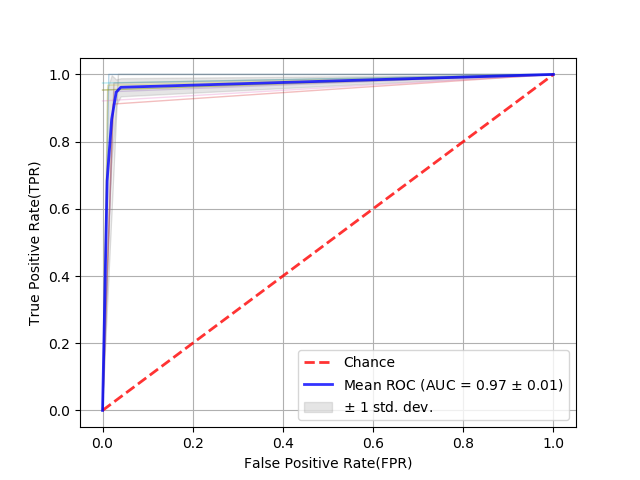

Evaluation Score: 97.64


In [233]:
# Classification using K-Fold Cross Validation
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

from sklearn import metrics
from scipy import interp
from sklearn.metrics import roc_curve, auc

splits = 10
kf = KFold(n_splits=splits)  # 10-Fold Cross Validation

X = np.asarray(feature_data_vt)/feature_data_vt.max()
X_eval = np.asarray(feature_data_vt_eval)/feature_data_vt_eval.max()
y = np.asarray(feature_label)
y_eval = np.asarray(feature_label_eval)
X, y = shuffle(X, y)
X_eval, y_eval = shuffle(X_eval, y_eval)

tprs, fprs, aucs, mean_tprs = [], [], [], []
mean_fpr = np.linspace(0, 1, 100)

clf = MLPClassifier(hidden_layer_sizes=(40), activation='relu', solver='adam', shuffle=True, random_state=42, verbose=False)
#clf = KNeighborsClassifier(n_neighbors=3)
#clf = SVC(kernel="rbf", gamma=0.7)
#clf = RandomForestClassifier()
counter = 1
for train, test in kf.split(X):
    printProgressBar(i-1, splits , prefix = 'Classification-Progress:', suffix = 'Complete', length = 50)
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    clf.fit(X_train, y_train)
    #print( "Classification for fold No. " + str(counter) + ": {0:.2f}".format(clf.score(X_test, y_test)*100) + "%")
    
    prediction = clf.predict(X_test)
    fpr, tpr, thresh = roc_curve(y_test, prediction)
    roc_auc = auc(fpr, tpr)
    tprs.append(tpr)
    fprs.append(fpr)
    aucs.append(roc_auc)
    mean_tprs.append(interp(mean_fpr, fpr, tpr))
    mean_tprs[-1][0] = 0.0
    counter += 1
print("\n")

plt.close(3)
fig3 = plt.figure(3)
plt.clf()
plt.grid()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")

for i in range(len(tprs)):
    plt.plot(fprs[i], tprs[i], lw=1, alpha=0.3)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

mean_tpr = np.mean(mean_tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(mean_tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()

print("Evaluation Score: {0:.2f}".format(clf.score(X_eval, y_eval)*100))